# HDBSCAN Clustering for Betacov sequences
---
### Parquet Making
We will be making a parquet for the entire file. Then we can sample from it randomly.

Making the parquet.

In [25]:
import os
import sys
import torch
import time
import datetime
import pandas as pd
from torch.utils.data import Dataset, DataLoader

from transformers import EsmTokenizer, EsmModel 

import lightning as L

# Parquet Making
class BetaCovDataset(Dataset):
    """ BetaCorona virus sequence dataset. """

    def __init__(self, csv_file:str):
        try:
            self.df = pd.read_csv(csv_file, sep=',', header=0, na_filter=False)
        except (FileNotFoundError, pd.errors.ParserError, Exception) as e:
            print(f"Error reading in .csv file: {csv_file}\n{e}", file=sys.stderr)
            sys.exit(1)

        self.df['variant'] = self.df['variant'].replace({
            'MERS': 'MERSV',
            'Sars-Cov-1': 'SARS-CoV-1',
            'Sars-Cov-2': 'SARS-CoV-2'
        })

        self.max_len = self.df['sequence'].apply(len).max()

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        return self.df.iloc[idx]["seq_id"], self.df.iloc[idx]["variant"], self.df.iloc[idx]["host"], self.df.iloc[idx]["sequence"]

class BetaCovDataModule(L.LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int, num_workers: int, seed: int):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed

        # Set seeds globally for reproducibility
        L.seed_everything(self.seed, workers=True)

    def setup(self, stage):
        # Called on every GPU
        if stage == 'test':
            self.test_dataset = BetaCovDataset(os.path.join(self.data_dir, "betacoronavirus_seq.csv"))

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            drop_last=False, 
            num_workers=self.num_workers,
            generator=torch.Generator().manual_seed(self.seed),
            pin_memory=True
        )

class LightningProteinEsmEmbedder(L.LightningModule):
    def __init__(self, max_len: int, csv_file:str, esm_version="facebook/esm2_t6_8M_UR50D", from_esm_mlm=None):
        super().__init__()
        self.tokenizer = EsmTokenizer.from_pretrained(esm_version, cache_dir="../../.cache")
        self.model = EsmModel.from_pretrained(esm_version, cache_dir="../../.cache")
        self.from_esm_mlm = from_esm_mlm
        self.max_len = max_len
        self.csv_file = csv_file
        self.batch_dataframes = []

        # Load fine-tuned weights from Lightning ESM_MLM ckpt
        if from_esm_mlm is not None:
            if trainer.global_rank == 0: print(f"Loading ESM_MLM checkpoint from {from_esm_mlm}...")

            ckpt = torch.load(from_esm_mlm, map_location="cpu")
            state_dict = ckpt["state_dict"]

            # Remove "model." prefix and filter out EsmMaskedLM specific keys
            new_state_dict = {}
            for key, value in state_dict.items():
                # Remove "model." prefix
                new_key = key.replace("model.esm.", "model.")

                # Filter out EsmMaskedLM keys (e.g., lm_head.*)
                if "lm_head" not in new_key:
                    new_state_dict[new_key] = value

            # Load weights non-strictly
            missing, unexpected = self.load_state_dict(new_state_dict, strict=False)

            # Define keys to ignore in missing list, these won't exist in the ESM_MLM
            ignored_missing = {
                'model.pooler.dense.weight', 'model.pooler.dense.bias'
            }

            # Filter out ignored missing keys
            filtered_missing = [k for k in missing if k not in ignored_missing]

            # Raise error if any unexpected keys are missing
            if filtered_missing: raise RuntimeError(f"Missing unexpected keys from ESM_MLM checkpoint: {filtered_missing}")

            if trainer.global_rank == 0:
                print("ESM_MLM checkpoint loaded successfully.")

                if unexpected: print("Unexpected keys:", unexpected)

    def forward(self, input_ids, attention_mask):
        esm_last_hidden_state = self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state # shape: [batch_size, sequence_length, embedding_dim]
        esm_cls_embedding = esm_last_hidden_state[:, 0, :]  # CLS token embedding (sequence-level representations), [batch_size, embedding_dim]
        return esm_cls_embedding

    def test_step(self, batch, batch_idx):
        seq_ids, variants, hosts, seqs = batch

        tokenized_seqs = self.tokenizer(seqs, return_tensors="pt", padding=True, truncation=True, max_length=self.max_len)
        tokenized_seqs = {k: v.to(self.device) for k, v in tokenized_seqs.items()}

        cls_embeddings = self(input_ids=tokenized_seqs["input_ids"], attention_mask=tokenized_seqs["attention_mask"])

        # Create a DataFrame for the batch
        batch_df = pd.DataFrame({
            "seq_id": seq_ids,
            "variant": variants,
            "host": hosts,
            "embedding": [embedding.detach().cpu().numpy() for embedding in cls_embeddings]  # Convert tensor to numpy array for each embedding
        })

        self.batch_dataframes.append(batch_df)

    def on_test_epoch_end(self):
        # Concatenate all batch DataFrames into one
        result_df = pd.concat(self.batch_dataframes, ignore_index=True)
    
        # Save data to a Parquet file
        save_as = self.csv_file.replace(".csv", f"{'.from-esm-mlm.' if self.from_esm_mlm is not None else '.'}CLS-embedded.parquet")
        result_df.to_parquet(save_as, index=False)
        print(f"Data saved to {save_as}.")

seed = 0
L.seed_everything(seed)  # Set seed for reproducibility
data_dir = "../../../data/betacov"

# Trainer setup 
trainer= L.Trainer(
    limit_test_batches=1.0, # 1.0 is 100% of batches 
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    num_nodes=1,
    devices=1,
    logger=False,
    enable_progress_bar=True
)

# Initialize DataModule and model
dm = BetaCovDataModule(
    data_dir = data_dir,
    batch_size = 64,
    num_workers = 4, 
    seed = seed
)
dm.setup("test")

model = LightningProteinEsmEmbedder(
    max_len = dm.test_dataset.max_len + 2, # Account for CLS, EOS tokens
    csv_file = os.path.join(data_dir, "betacoronavirus_seq.csv"),
    esm_version = "facebook/esm2_t6_8M_UR50D",
    from_esm_mlm = "../best_model-epoch=73.val_loss=0.0022.val_accuracy=99.6612.ckpt"
)

start_time = time.perf_counter()
trainer.test(model, dm)  # Test model
duration = datetime.timedelta(seconds=time.perf_counter()-start_time)
print(f"[Timing] Test.fit(...) took: {duration} (hh:mm:ss).")

Seed set to 0
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
Seed set to 0
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading ESM_MLM checkpoint from ../best_model-epoch=73.val_loss=0.0022.val_accuracy=99.6612.ckpt...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


ESM_MLM checkpoint loaded successfully.
Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]
[Timing] Test.fit(...) took: 0:00:00.565930 (hh:mm:ss).


---
### Clustering - tSNE, then HDBSCAN
Apply tSNE to the embeddings, then save the tSNE embeddings.

In [26]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import hdbscan
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from openTSNE import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score

def best_perplexity(parquet_file, perp_list, min_samples_max=51, min_cluster_size_max=51):
    embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
    embedding_matrix = np.vstack(embedded_df["embedding"])

    for perp in perp_list:
        tsne_reducer = TSNE(n_components=2, perplexity=perp, learning_rate='auto', random_state=42, n_jobs=8)
        embedding_matrix_reduced = tsne_reducer.fit(embedding_matrix)

        results = []

        for ms in range(1, min_samples_max):
            for mcs in range(2, min_cluster_size_max):
                clusterer = hdbscan.HDBSCAN(
                    min_samples=ms,
                    min_cluster_size=mcs,
                    core_dist_n_jobs=-1
                ).fit(embedding_matrix_reduced)

                labels = clusterer.labels_
                ari = adjusted_rand_score(embedded_df["variant"], labels)

                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                silhouette_avg = silhouette_score(embedding_matrix_reduced, labels) if n_clusters > 1 else np.nan

                results.append({
                    "min_sample": ms,
                    "min_cluster_size": mcs,
                    "ari": ari,
                    "silhouette": silhouette_avg
                })

        df = pd.DataFrame(results)
        ari_matrix = df.pivot(index='min_sample', columns='min_cluster_size', values='ari')
        silhouette_matrix = df.pivot(index='min_sample', columns='min_cluster_size', values='silhouette')

        max_ari = ari_matrix.max().max()
        max_ari_idx = ari_matrix.stack().idxmax()
        max_min_sample, max_min_cluster_size = max_ari_idx
        associated_sc = silhouette_matrix.loc[max_min_sample, max_min_cluster_size]

        print(f"[Perplexity={perp}] Max ARI: {max_ari:.4f}, assoc. SC: {associated_sc:.4f} @ min_sample={max_min_sample}, min_cluster_size={max_min_cluster_size}")

# Load in the data
data_dir = "../../../data/betacov"
parquet_file = os.path.join(data_dir, f"betacoronavirus_seq.from-esm-mlm.CLS-embedded.parquet")

best_perplexity(parquet_file, perp_list=range(1, (75//3)+1), min_samples_max=26, min_cluster_size_max=26)

[Perplexity=1] Max ARI: 0.3558, assoc. SC: 0.4764 @ min_sample=4, min_cluster_size=6
[Perplexity=2] Max ARI: 0.6166, assoc. SC: 0.6068 @ min_sample=4, min_cluster_size=6
[Perplexity=3] Max ARI: 0.9224, assoc. SC: 0.5848 @ min_sample=7, min_cluster_size=11
[Perplexity=4] Max ARI: 0.6716, assoc. SC: 0.6965 @ min_sample=6, min_cluster_size=8
[Perplexity=5] Max ARI: 0.6739, assoc. SC: 0.5251 @ min_sample=14, min_cluster_size=2
[Perplexity=6] Max ARI: 0.6679, assoc. SC: 0.7157 @ min_sample=1, min_cluster_size=10
[Perplexity=7] Max ARI: 0.5610, assoc. SC: 0.6290 @ min_sample=7, min_cluster_size=2
[Perplexity=8] Max ARI: 0.6679, assoc. SC: 0.6858 @ min_sample=1, min_cluster_size=10
[Perplexity=9] Max ARI: 0.5969, assoc. SC: 0.7211 @ min_sample=6, min_cluster_size=2
[Perplexity=10] Max ARI: 0.7252, assoc. SC: 0.7153 @ min_sample=1, min_cluster_size=11
[Perplexity=11] Max ARI: 0.6679, assoc. SC: 0.6463 @ min_sample=1, min_cluster_size=12
[Perplexity=12] Max ARI: 0.6165, assoc. SC: 0.7773 @ min_

Perplexity value 25 is too high. Using perplexity 24.67 instead


[Perplexity=24] Max ARI: 0.5767, assoc. SC: 0.7149 @ min_sample=7, min_cluster_size=2
[Perplexity=25] Max ARI: 0.5863, assoc. SC: 0.6949 @ min_sample=1, min_cluster_size=7


This takes way too long for the omicron and rbd files due to the number of sequences. Have to break it up into sections.

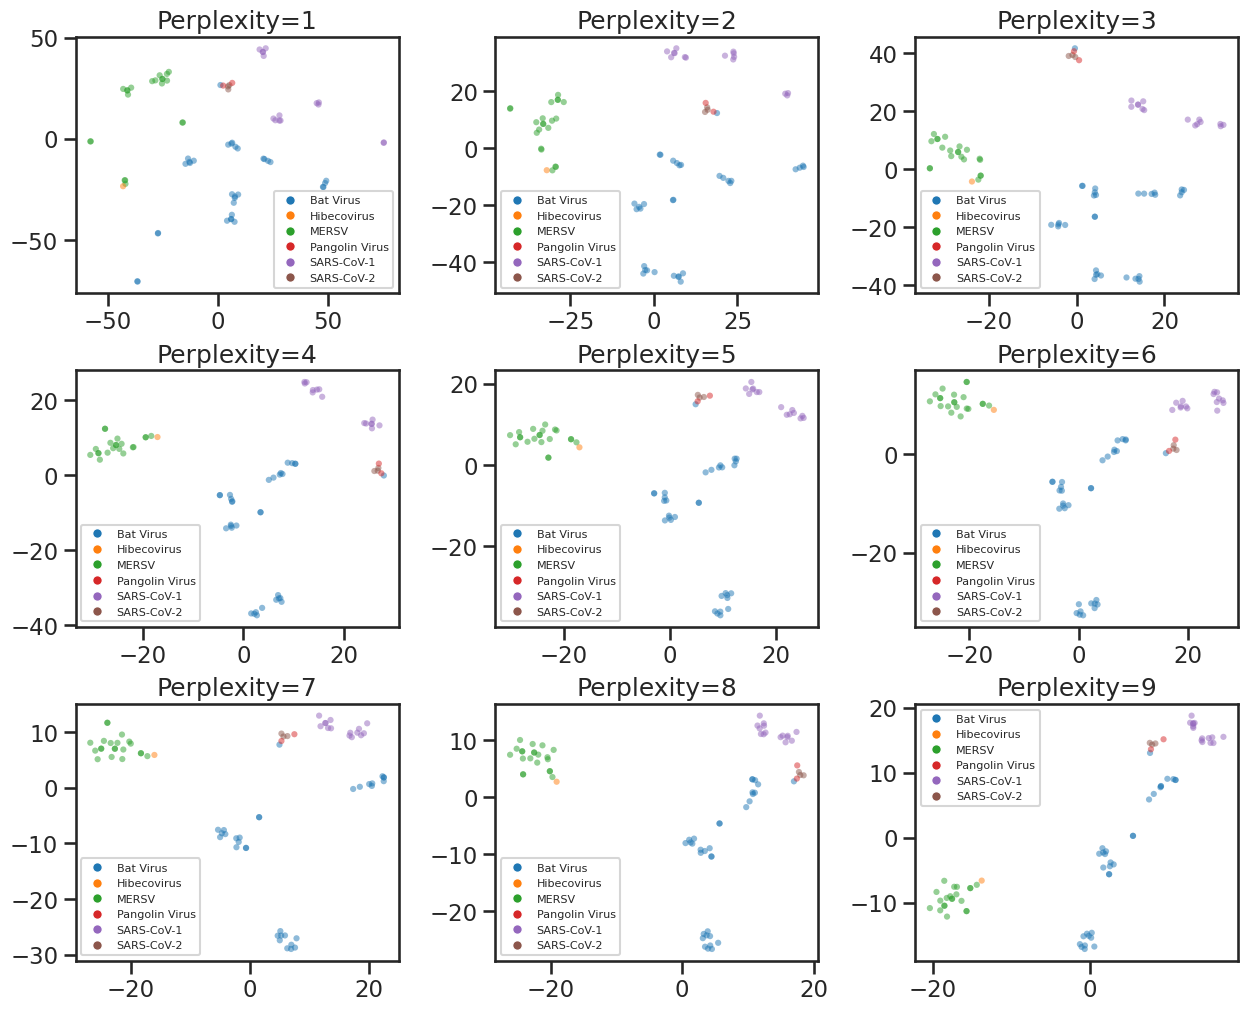

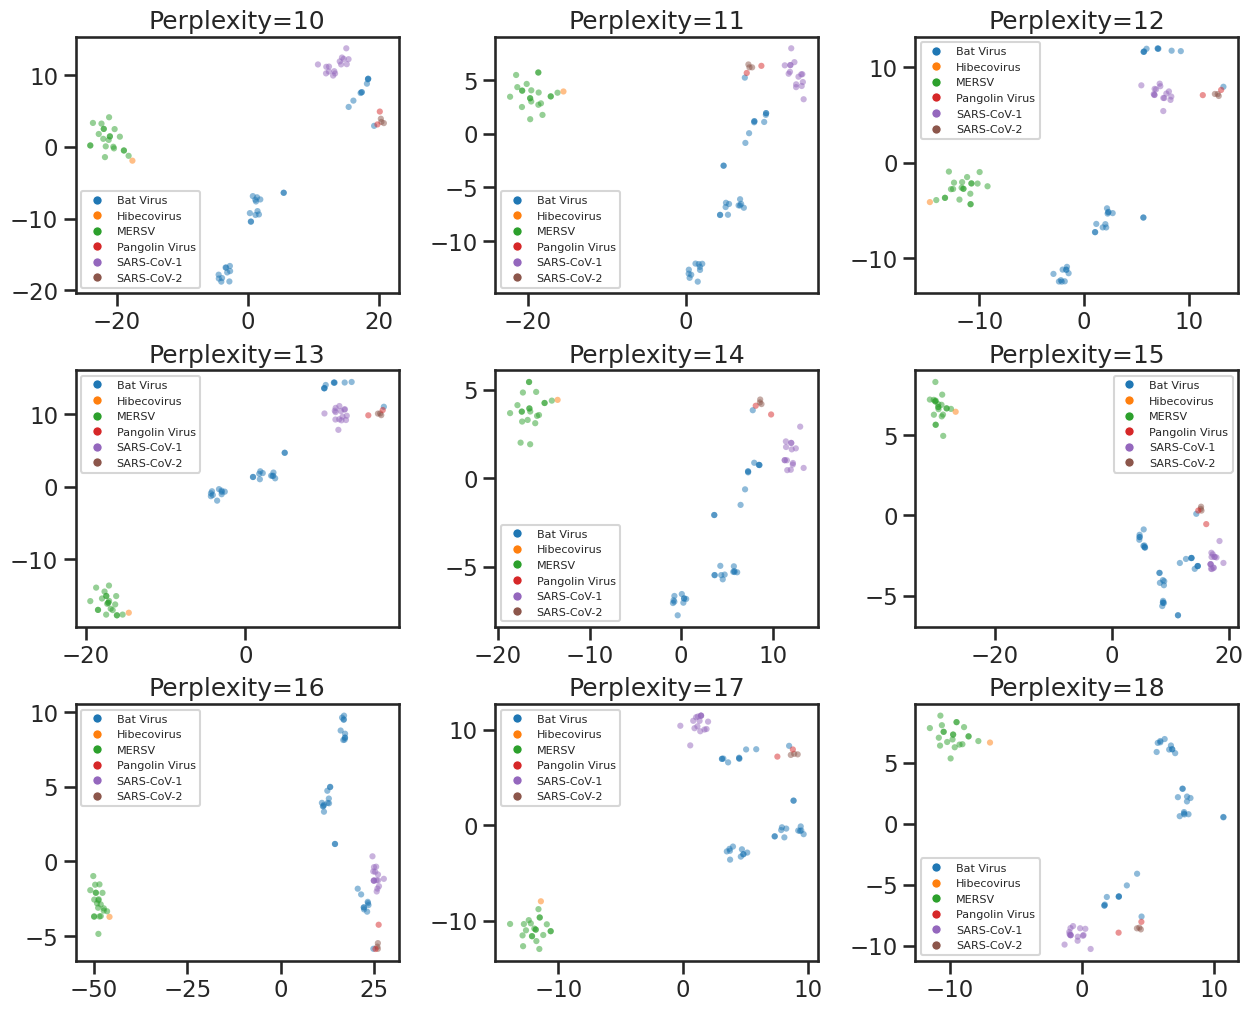

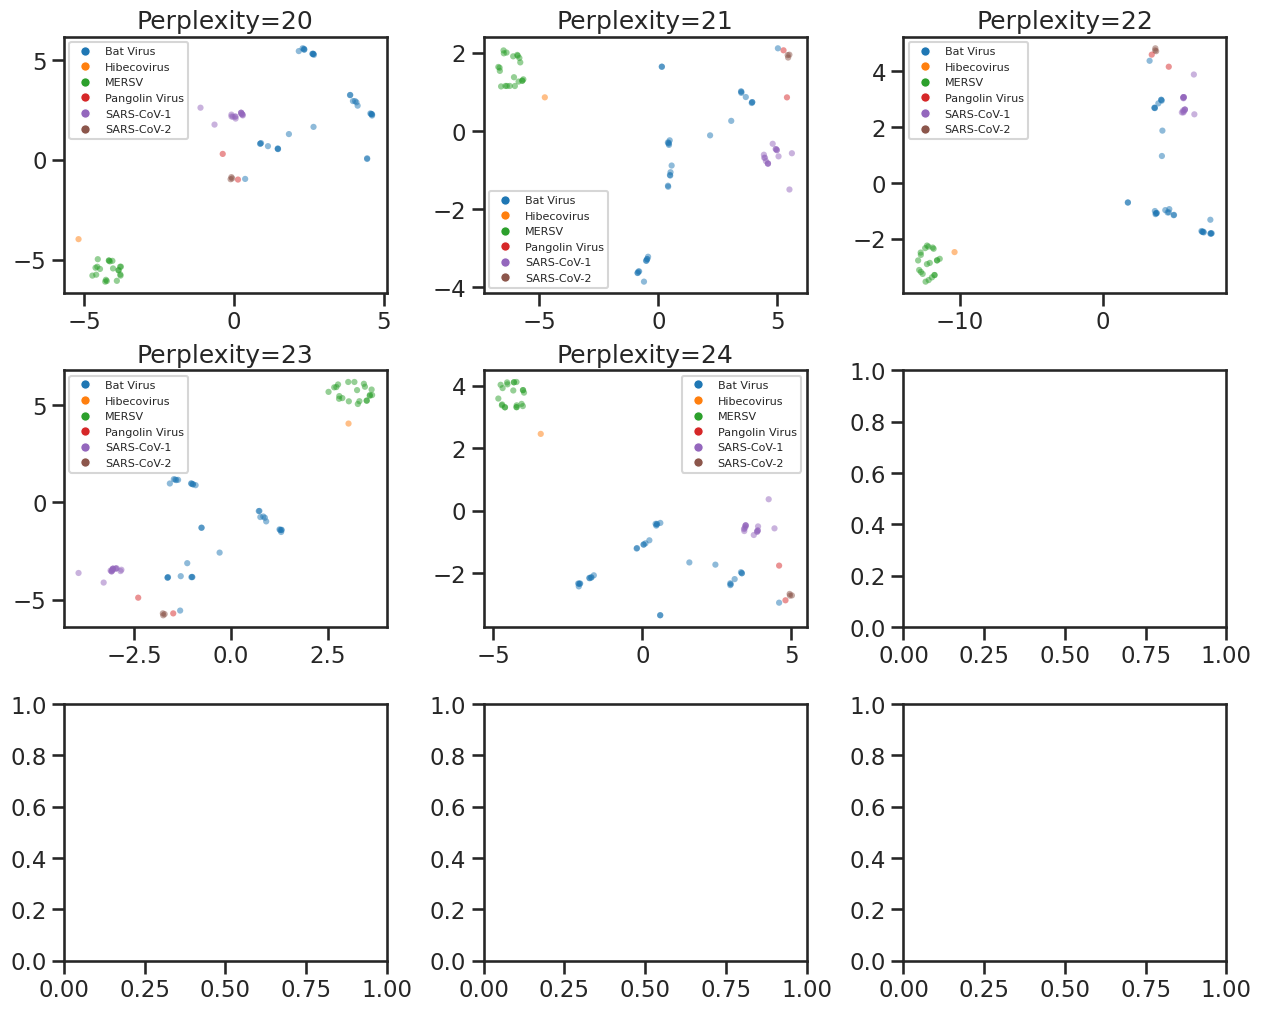

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from openTSNE import TSNE

def plot_perplexities(parquet_file, perp_list):
    n_rows = 3
    n_cols = 3
    sns.set_style('ticks')
    sns.set_context("talk")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
    embedding_matrix = np.vstack(embedded_df["embedding"])

    for ax, perp in zip(axes.flat, perp_list):

        tsne_reducer = TSNE(n_components=2, perplexity=perp, learning_rate='auto', random_state=42, n_jobs=8)
        embedding_matrix_reduced = tsne_reducer.fit(embedding_matrix)

        plot_df = pd.DataFrame({
            't-SNE component 1': embedding_matrix_reduced[:, 0],
            't-SNE component 2': embedding_matrix_reduced[:, 1],
            'Seq ID': embedded_df['seq_id'],
            'Variant': embedded_df['variant'],
            'Host': embedded_df['host']
        })
        #save_as = parquet_file.replace(".parquet", f".tSNE-perplexity{perp}.parquet")
        #plot_df.to_parquet(save_as, engine='fastparquet')

        unique_variants = np.unique(plot_df['Variant'])
        variant_color_palette = sns.color_palette("tab10", n_colors=len(unique_variants)) 
        variant_color_dict = {label: color for label, color in zip(unique_variants, variant_color_palette)}
        variant_colors = [variant_color_dict[v] for v in plot_df['Variant']]

        ax.scatter(plot_df['t-SNE component 1'], plot_df['t-SNE component 2'],
                c=variant_colors, s=20, alpha=0.5, edgecolor='none', linewidth=0)
        ax.set_title(f'Perplexity={perp}')
        
        # Create per-plot legend
        handles = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=variant_color_dict[v], markersize=7)
            for v in unique_variants
        ]
        labels = unique_variants
        ax.legend(handles, labels, loc='best', fontsize=8, title_fontsize=9)

    plt.show()

data_dir = "../../../data/betacov"
plot_perplexities(
    parquet_file = os.path.join(data_dir, f"betacoronavirus_seq.from-esm-mlm.CLS-embedded.parquet"),
    perp_list = range(1,10)
)
plot_perplexities(
    parquet_file = os.path.join(data_dir, f"betacoronavirus_seq.from-esm-mlm.CLS-embedded.parquet"),
    perp_list = range(10,20)
)
plot_perplexities(
    parquet_file = os.path.join(data_dir, f"betacoronavirus_seq.from-esm-mlm.CLS-embedded.parquet"),
    perp_list = range(20, 25)
)

Find highest or a sufficiently highest Silhouette Coefficient, Adjusted Rand Index.

min_sample 1, min_cluster_size 2: Adjusted Rand Index: 0.14, Silhouette Coefficient: 0.64
min_sample 1, min_cluster_size 3: Adjusted Rand Index: 0.24, Silhouette Coefficient: 0.69
min_sample 1, min_cluster_size 4: Adjusted Rand Index: 0.26, Silhouette Coefficient: 0.69
min_sample 1, min_cluster_size 5: Adjusted Rand Index: 0.48, Silhouette Coefficient: 0.76
min_sample 1, min_cluster_size 6: Adjusted Rand Index: 0.55, Silhouette Coefficient: 0.74
min_sample 1, min_cluster_size 7: Adjusted Rand Index: 0.55, Silhouette Coefficient: 0.74
min_sample 1, min_cluster_size 8: Adjusted Rand Index: 0.55, Silhouette Coefficient: 0.63
min_sample 1, min_cluster_size 9: Adjusted Rand Index: 0.55, Silhouette Coefficient: 0.63
min_sample 1, min_cluster_size 10: Adjusted Rand Index: 0.67, Silhouette Coefficient: 0.63
min_sample 1, min_cluster_size 11: Adjusted Rand Index: 0.87, Silhouette Coefficient: 0.61
min_sample 1, min_cluster_size 12: Adjusted Rand Index: 0.87, Silhouette Coefficient: 0.61
min_sam

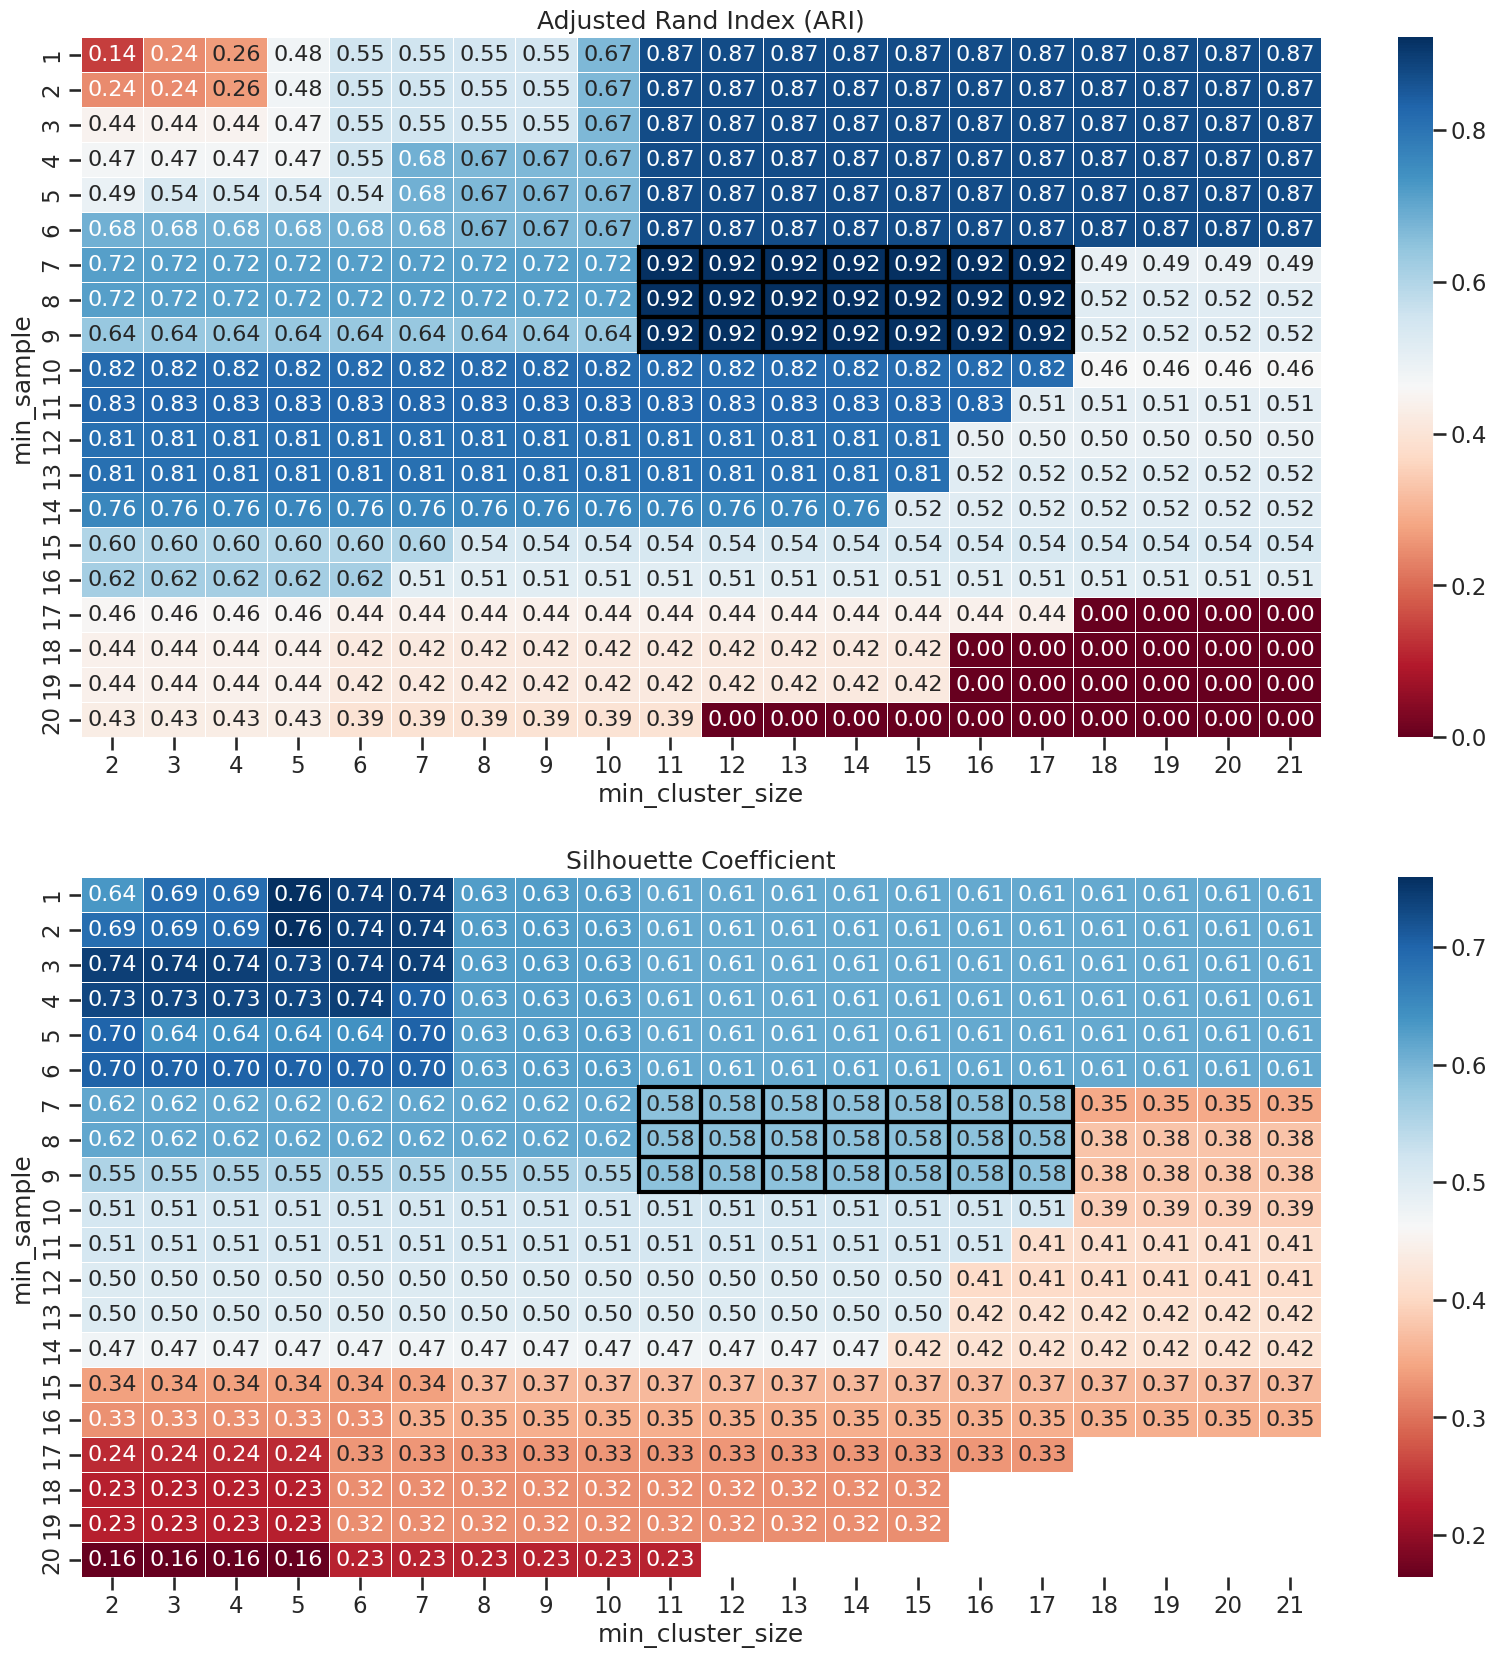

In [62]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def ari_sc_heatmap(parquet_file, min_samples_max, min_cluster_size_max):
    embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
    embedding_matrix = embedded_df[['t-SNE component 1', 't-SNE component 2']].values

    results = []
    for ms in range(1, min_samples_max):
        for mcs in range(2, min_cluster_size_max):
            # Cluster
            clusterer = hdbscan.HDBSCAN(
                min_samples=ms,
                min_cluster_size=mcs,
                core_dist_n_jobs=-1
            ).fit(embedding_matrix)

            labels = clusterer.labels_

            # Evaluate clustering
            ari = adjusted_rand_score(embedded_df["Variant"], labels)

            # Check number of clusters (excluding noise)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1:
                silhouette_avg = silhouette_score(embedding_matrix, labels)
            else:
                silhouette_avg = np.nan  # or 0, depending on how you want to treat it

            # Store results
            results.append({
                "min_sample": ms,
                "min_cluster_size": mcs,
                "ari": ari,
                "silhouette": silhouette_avg
            })

            print(f"min_sample {ms}, min_cluster_size {mcs}: Adjusted Rand Index: {ari:.2f}, Silhouette Coefficient: {silhouette_avg:.2f}")

    # Convert to DataFrame
    df = pd.DataFrame(results)

    # Pivot matrices
    ari_matrix = df.pivot(index='min_sample', columns='min_cluster_size', values='ari')
    silhouette_matrix = df.pivot(index='min_sample', columns='min_cluster_size', values='silhouette')

    # Plot heatmaps
    sns.set_style('ticks')
    sns.set_context("talk")
    fig, axs = plt.subplots(2, 1, figsize=(20, 20))

    sns.heatmap(ari_matrix, annot=True, annot_kws={"size": 16}, fmt=".2f", linewidth=.5, cmap="RdBu", ax=axs[0])
    axs[0].set_title("Adjusted Rand Index (ARI)")
    axs[0].set_xlabel("min_cluster_size")
    axs[0].set_ylabel("min_sample")

    max_ari = ari_matrix.max().max()  # Get the max ARI value

    for i in range(ari_matrix.shape[0]):  # min_sample (rows)
        for j in range(ari_matrix.shape[1]):  # min_cluster_size (cols)
            if np.isclose(ari_matrix.iloc[i, j], max_ari):  # Safe float comparison
                axs[0].add_patch(
                    plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=3)
                )

    sns.heatmap(silhouette_matrix, annot=True, annot_kws={"size": 16}, fmt=".2f", linewidth=.5, cmap="RdBu", ax=axs[1])
    axs[1].set_title("Silhouette Coefficient")
    axs[1].set_xlabel("min_cluster_size")
    axs[1].set_ylabel("min_sample")

    for i in range(ari_matrix.shape[0]):  # min_sample (rows)
        for j in range(ari_matrix.shape[1]):  # min_cluster_size (cols)
            if np.isclose(ari_matrix.iloc[i, j], max_ari):  # Safe float comparison
                axs[1].add_patch(
                    plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=3)
                )
    save_as = parquet_file.replace(".parquet", ".HDBSCAN_heatmap")
    plt.savefig(f"{save_as}.pdf", format="pdf", dpi=300, bbox_inches='tight')
    plt.show()

data_dir = "../../../data/betacov"
parquet_file = os.path.join(data_dir, f"betacoronavirus_seq.from-esm-mlm.CLS-embedded.parquet")
embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_df["embedding"])

# Save the embedding based off best perplexity
perp = 3
tsne_reducer = TSNE(n_components=2, perplexity=perp, learning_rate='auto', random_state=42, n_jobs=8)
embedding_matrix_reduced = tsne_reducer.fit(embedding_matrix)

plot_df = pd.DataFrame({
    't-SNE component 1': embedding_matrix_reduced[:, 0],
    't-SNE component 2': embedding_matrix_reduced[:, 1],
    'Seq ID': embedded_df['seq_id'],
    'Variant': embedded_df['variant'],
    'Host': embedded_df['host']
})
save_as = f"BETACOV.from-esm-mlm.CLS-embedded.tSNE-perplexity{perp}.parquet"
plot_df.to_parquet(save_as, engine='fastparquet')

# Load the embedding
perp = 3
parquet_file = f"BETACOV.from-esm-mlm.CLS-embedded.tSNE-perplexity{perp}.parquet"
ari_sc_heatmap(parquet_file, min_samples_max=21, min_cluster_size_max=22)

Plotting the tSNE embeddings after applying HDBSCAN.

min_sample 7, min_cluster_size 11: Adjusted Rand Index: 0.92, Silhouette Coefficient: 0.58


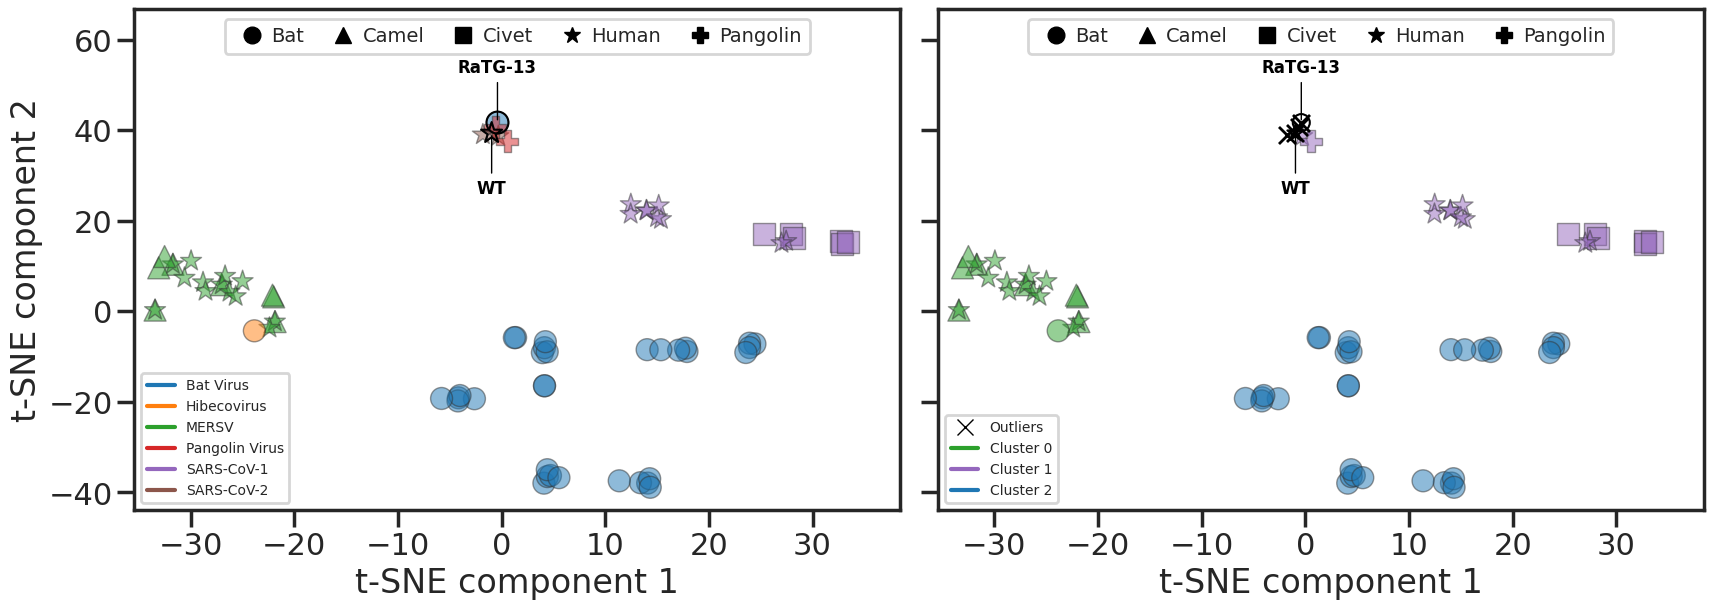

   t-SNE component 1  t-SNE component 2  Cluster    Seq ID    Variant Host
3          24.440416          -7.191122        2  KT444582  Bat Virus  Bat
5          23.924021          -7.034724        2  KF367457  Bat Virus  Bat
6          23.925508          -7.994940        2  KY417151  Bat Virus  Bat
9          23.562956          -9.088177        2  KF569996  Bat Virus  Bat


Predicted Clusters,-1,0,1,2
Ground Truth,,,,
Bat Virus,3.03,0.0,0.00,96.97
Hibecovirus,0.00,100.0,0.00,0.00
MERSV,0.00,100.0,0.00,0.00
Pangolin Virus,50.00,0.0,50.00,0.00
SARS-CoV-1,0.00,0.0,100.00,0.00
SARS-CoV-2,66.67,0.0,33.33,0.00


In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score

def get_hdbscan_values(parquet_file, min_samples, min_cluster_size):
    embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
    embedding_matrix = embedded_df[['t-SNE component 1', 't-SNE component 2']].values

    # Cluster
    hdb_labels = hdbscan.HDBSCAN(
        min_samples=min_samples,
        min_cluster_size=min_cluster_size,
        core_dist_n_jobs=-1  # Enable parallel processing
    ).fit(embedding_matrix).labels_

    # Evaluate clustering
    silhouette_avg = silhouette_score(embedding_matrix, hdb_labels)
    ari = adjusted_rand_score(embedded_df["Variant"], hdb_labels)
    print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Adjusted Rand Index: {ari:.2f}, Silhouette Coefficient: {silhouette_avg:.2f}")

    # Create the truth table
    truth_table_percent = pd.crosstab(embedded_df["Variant"], hdb_labels, 
                                    rownames=['Ground Truth'], 
                                    colnames=['Predicted Clusters'],
                                    normalize='index')  # Normalize along the index (rows)
    truth_table_percent = (truth_table_percent * 100).round(2)

    # Save
    plot_df = pd.DataFrame({
        't-SNE component 1': embedding_matrix[:, 0],
        't-SNE component 2': embedding_matrix[:, 1],
        'Cluster': hdb_labels,
        'Seq ID': embedded_df['Seq ID'],
        'Variant': embedded_df['Variant'],
        'Host': embedded_df['Host'],
    })    
    save_as = parquet_file.replace(".parquet", f".HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-ari{ari:.2f}_sc{silhouette_avg:.2f}")
    plot_df.to_parquet(f"{save_as}.parquet", engine='fastparquet')
    
    return plot_df, truth_table_percent, save_as

def plot_groundtruth_prediction_1x2(plot_df, save_as, annotation_labels, x_min_width_buffer, x_max_width_buffer, y_min_width_buffer, y_max_width_buffer, color_map, cluster_color_palette_order):
    marker_size = 250

    # Define a host shape palette
    unique_hosts = np.unique(plot_df['Host'])
    host_marker_palette = ['o', '^', 's', '*', 'P', 'D', 'v', 'p', '.', '>', '<', 'd', 'H', 'h', '8']   # Use only filled markers
    host_marker_dict = {label: marker for label, marker in zip(unique_hosts, host_marker_palette)}
    
    # Define a variant color palette
    unique_variants = np.unique(plot_df['Variant'])
    variant_color_palette = sns.color_palette(color_map, n_colors=len(unique_variants)) 
    variant_color_dict = {label: color for label, color in zip(unique_variants, variant_color_palette)}

    # Define a cluster color palette
    unique_clusters = np.unique(plot_df['Cluster'])
    cluster_color_palette = sns.color_palette(color_map, n_colors=10) 
    cluster_color_palette = [cluster_color_palette[i] for i in cluster_color_palette_order]
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_color_palette)}
    cluster_color_dict[-1] = 'black'  # Set outliers to x

    sns.set_style('ticks')
    sns.set_context("poster")
    fig, axs = plt.subplots(1, 2, figsize=(20.25, 6.5), sharey=True)
    fig.subplots_adjust(wspace=0.05)  # Reduce the horizontal space between subplots

    #####################################################

    # Scatterplot
    sns.scatterplot(
        data=plot_df,
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Variant', palette=variant_color_dict, 
        style='Host', markers=host_marker_dict,  
        s=marker_size, alpha=0.5, edgecolor=".2", linewidth=1,
        ax=axs[0]
    )

    # Outline points in black 
    annotate_df = plot_df[plot_df['Seq ID'].isin(annotation_labels)]
    sns.scatterplot(
        data=annotate_df,
        x='t-SNE component 1', y='t-SNE component 2',
        style='Host', markers=host_marker_dict,  
        s=marker_size, edgecolor='black', facecolor='none', linewidth=1.5,
        ax=axs[0]
    )

    # Annotate points
    for idx, row in annotate_df.iterrows():
        if row['Seq ID'] in annotation_labels:  # Only annotate specified labels
            x, y = row['t-SNE component 1'], row['t-SNE component 2']
            if row['Seq ID'] == 'MN908947': label = "WT"
            elif row['Seq ID'] == 'MN996532': label = "RaTG-13"
            else: label = row['Seq ID']
            x_offset, y_offset = annotation_labels.get(row['Seq ID']) 
                        
            axs[0].annotate(
                label, 
                (x, y), xytext=(x_offset, y_offset), textcoords='offset points',
                color='k',
                fontsize=12, fontweight='bold', ha='center', va='center',
                arrowprops=dict(arrowstyle="-", color='k', lw=1)
            )

    axs[0].set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+x_max_width_buffer))
    axs[0].set_ylim(plot_df['t-SNE component 2'].min()-y_min_width_buffer, plot_df['t-SNE component 2'].max()+y_max_width_buffer),

    # Legend 
    host_handles = [
        plt.Line2D([0], [0], marker=host_marker_dict[host], color='black', linestyle='none', label=f'{host}')
        for host in unique_hosts
    ]
    variant_handles = [
        plt.Line2D([0], [0], color=variant_color_dict[variant], label=f'{variant}')
        for variant in unique_variants
    ]
    # axs[0].legend(handles=variant_handles+host_handles)
    host_legend = axs[0].legend(handles=host_handles, ncol=5, columnspacing=1, handletextpad=0, loc="upper center", fontsize=14)
    variant_legend = axs[0].legend(handles=variant_handles, ncol=1, loc="lower left", fontsize=10)
    axs[0].add_artist(host_legend)
    
    # #####################################################

    # Scatterplot for non-outliers
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] != -1],  # Exclude outliers
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Cluster', palette=cluster_color_dict, 
        style='Host', markers=host_marker_dict,
        s=marker_size, alpha=0.5, edgecolor=".2", linewidth=1,
        ax=axs[1]
    )

    # Scatterplot for outliers (Cluster = -1)
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] == -1],  # Select only outliers
        x='t-SNE component 1', y='t-SNE component 2',
        marker='x',
        s=marker_size-100, color='black', linewidth=2,
        ax=axs[1]
    )

    # Outline points in black 
    annotate_df = plot_df[plot_df['Seq ID'].isin(annotation_labels)]
    sns.scatterplot(
        data=annotate_df[annotate_df['Cluster'] != -1],
        x='t-SNE component 1', y='t-SNE component 2',
        style='Host', markers=host_marker_dict,  
        s=marker_size, edgecolor='black', facecolor='none', linewidth=1.5,
        ax=axs[1]
    )

    sns.scatterplot(
        data=annotate_df[annotate_df['Cluster'] == -1],
        x='t-SNE component 1', y='t-SNE component 2',
        style='Host', markers=host_marker_dict,  
        s=marker_size-100, edgecolor='black', facecolor='none', linewidth=1.5,
        ax=axs[1]
    )

    # Annotate points
    for idx, row in annotate_df.iterrows():
        if row['Seq ID'] in annotation_labels:  # Only annotate specified labels
            x, y = row['t-SNE component 1'], row['t-SNE component 2']
            if row['Seq ID'] == 'MN908947': label = "WT"
            elif row['Seq ID'] == 'MN996532': label = "RaTG-13"
            else: label = row['Seq ID']
            x_offset, y_offset = annotation_labels.get(row['Seq ID']) 
                        
            axs[1].annotate(
                label, 
                (x, y), xytext=(x_offset, y_offset), textcoords='offset points',
                color='k',
                fontsize=12, fontweight='bold', ha='center', va='center',
                arrowprops=dict(arrowstyle="-", color='k', lw=1)
            )

    axs[1].set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+x_max_width_buffer))

    # Legend 
    host_handles = [
        plt.Line2D([0], [0], marker=host_marker_dict[host], color='black', linestyle='none', label=f'{host}')
        for host in unique_hosts
    ]
    cluster_handles = [plt.Line2D([0], [0], marker='x', color='black', linestyle='none', label='Outliers')]
    cluster_handles += [
        plt.Line2D([0], [0], color=cluster_color_dict[cluster], label=f'Cluster {cluster}')
        for cluster in unique_clusters if cluster != -1
    ]
    host_legend = axs[1].legend(handles=host_handles, ncol=5, columnspacing=1, handletextpad=0, loc="upper center", fontsize=14)
    cluster_legend = axs[1].legend(handles=cluster_handles, ncol=1, loc="lower left", fontsize=10)
    axs[1].add_artist(host_legend)

    #####################################################
  
    plt.savefig(f"{save_as}.pdf", format="pdf", dpi=600, bbox_inches='tight')
    plt.savefig(f"{save_as}.png", format="png", dpi=600, bbox_inches='tight')
    plt.show()

    print(plot_df[plot_df['Seq ID'].isin(["KF569996", "KT444582", "KF367457", "KY417151"])])

seed = 0
perp = 3
parquet_file = f"BETACOV.from-esm-mlm.CLS-embedded.tSNE-perplexity{perp}.parquet"

min_samples=7
min_cluster_size=11
plot_df, truth_table_percent, save_as = get_hdbscan_values(parquet_file, min_samples, min_cluster_size)

# Call the function
annotation_labels = {
    'MN908947':(0,-40),
    'MN996532':(0,40),
    # 'KF569996':(-75,0),
    # 'KT444582':(-10,-40),
    # 'KF367457':(-5,100),
    # 'KY417151':(-50,55)
}
plot_groundtruth_prediction_1x2(
    plot_df, save_as, annotation_labels, 
    x_min_width_buffer=2, x_max_width_buffer=5, y_min_width_buffer=5, y_max_width_buffer=25, 
    color_map="tab10",cluster_color_palette_order=[2,4,0,3,1,5,6,7,8,9]
)
truth_table_percent

In [10]:
phylo_df = plot_df.drop(columns=["t-SNE component 1", "t-SNE component 2"])
phylo_df.to_csv("betacov_clustering-from-esm-mlm.csv", index=False)

---
### Without the from_esm_mlm set:

In [30]:
seed = 0
L.seed_everything(seed)  # Set seed for reproducibility
data_dir = "../../../data/betacov"

# Trainer setup 
trainer= L.Trainer(
    limit_test_batches=1.0, # 1.0 is 100% of batches 
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    num_nodes=1,
    devices=1,
    logger=False,
    enable_progress_bar=True
)

# Initialize DataModule and model
dm = BetaCovDataModule(
    data_dir = data_dir,
    batch_size = 64,
    num_workers = 4, 
    seed = seed
)
dm.setup("test")

model = LightningProteinEsmEmbedder(
    max_len = dm.test_dataset.max_len + 2, # Account for CLS, EOS tokens
    csv_file = os.path.join(data_dir, "betacoronavirus_seq.csv"),
    esm_version = "facebook/esm2_t6_8M_UR50D",
)

start_time = time.perf_counter()
trainer.test(model, dm)  # Test model
duration = datetime.timedelta(seconds=time.perf_counter()-start_time)
print(f"[Timing] Test.fit(...) took: {duration} (hh:mm:ss).")

Seed set to 0
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
Seed set to 0
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]
[Timing] Test.fit(...) took: 0:00:00.691356 (hh:mm:ss).


In [31]:
# Load in the data
data_dir = "../../../data/betacov"
parquet_file = os.path.join(data_dir, f"betacoronavirus_seq.CLS-embedded.parquet")

best_perplexity(parquet_file, perp_list=range(1, (75//3)+1), min_samples_max=26, min_cluster_size_max=26)

[Perplexity=1] Max ARI: 0.3152, assoc. SC: 0.7010 @ min_sample=3, min_cluster_size=2
[Perplexity=2] Max ARI: 0.5835, assoc. SC: 0.3148 @ min_sample=13, min_cluster_size=8
[Perplexity=3] Max ARI: 0.5571, assoc. SC: 0.5711 @ min_sample=1, min_cluster_size=10
[Perplexity=4] Max ARI: 0.5571, assoc. SC: 0.6816 @ min_sample=1, min_cluster_size=10
[Perplexity=5] Max ARI: 0.5571, assoc. SC: 0.7167 @ min_sample=1, min_cluster_size=10
[Perplexity=6] Max ARI: 0.7157, assoc. SC: 0.7488 @ min_sample=2, min_cluster_size=8
[Perplexity=7] Max ARI: 0.7238, assoc. SC: 0.6885 @ min_sample=6, min_cluster_size=3
[Perplexity=8] Max ARI: 0.6683, assoc. SC: 0.7487 @ min_sample=1, min_cluster_size=8
[Perplexity=9] Max ARI: 0.6916, assoc. SC: 0.6665 @ min_sample=5, min_cluster_size=5
[Perplexity=10] Max ARI: 0.6683, assoc. SC: 0.7516 @ min_sample=1, min_cluster_size=8
[Perplexity=11] Max ARI: 0.6683, assoc. SC: 0.7653 @ min_sample=1, min_cluster_size=8
[Perplexity=12] Max ARI: 0.6966, assoc. SC: 0.6875 @ min_sa

Perplexity value 25 is too high. Using perplexity 24.67 instead


[Perplexity=24] Max ARI: 0.6688, assoc. SC: 0.7406 @ min_sample=5, min_cluster_size=6
[Perplexity=25] Max ARI: 0.5571, assoc. SC: 0.8368 @ min_sample=1, min_cluster_size=8


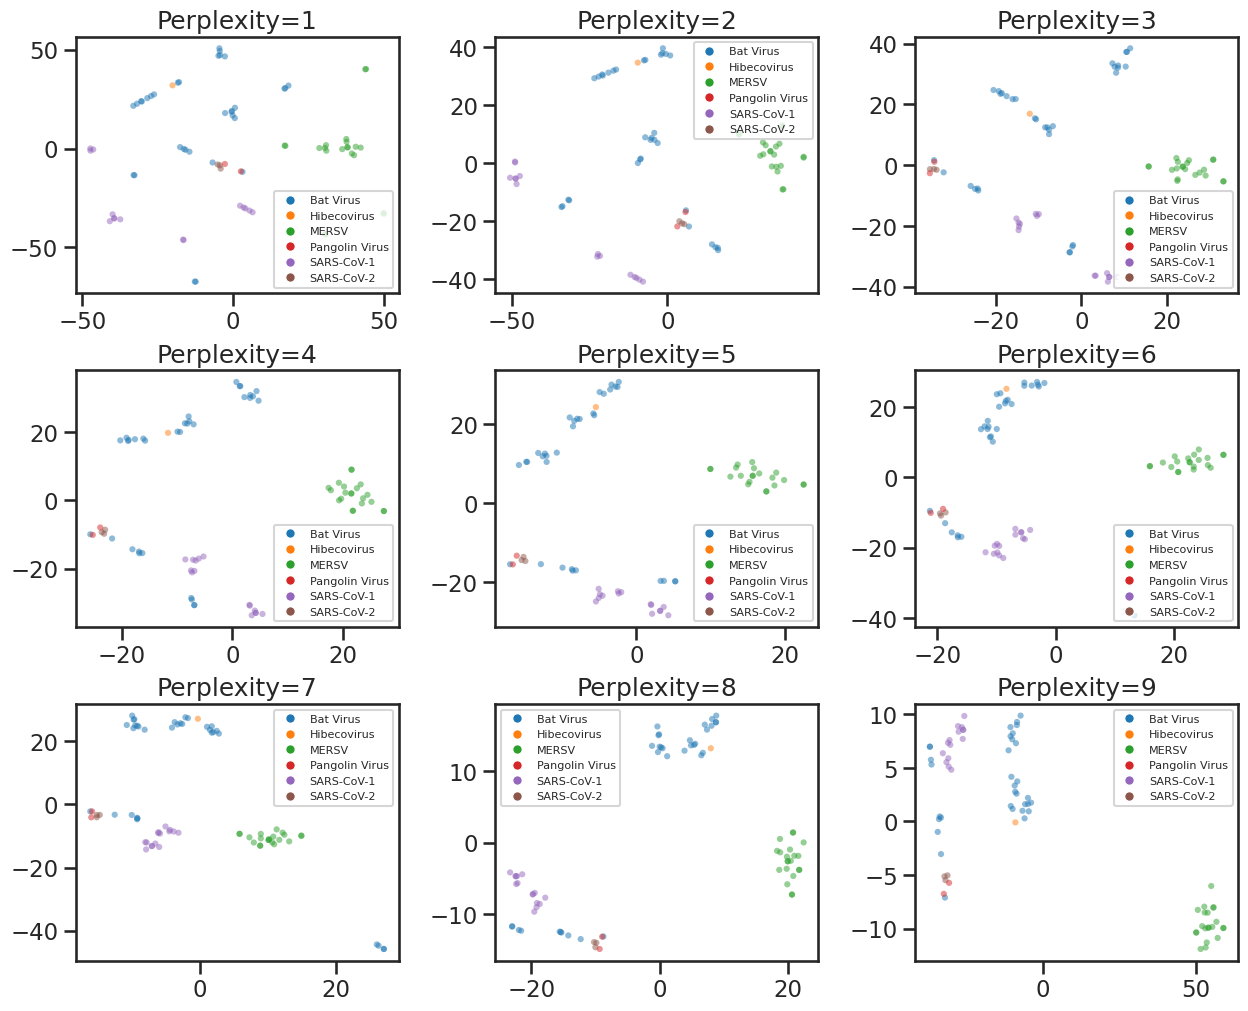

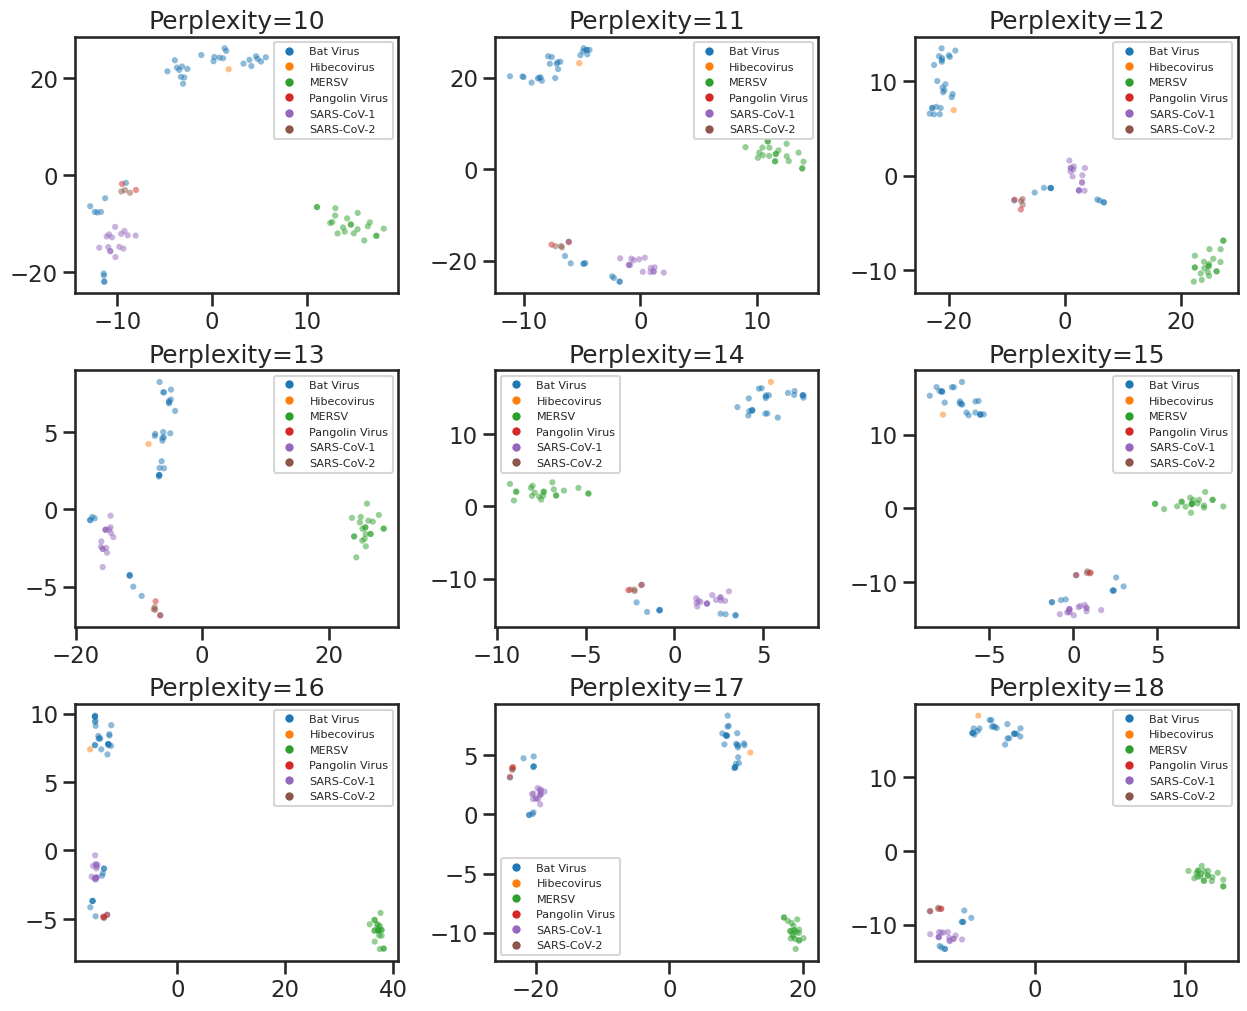

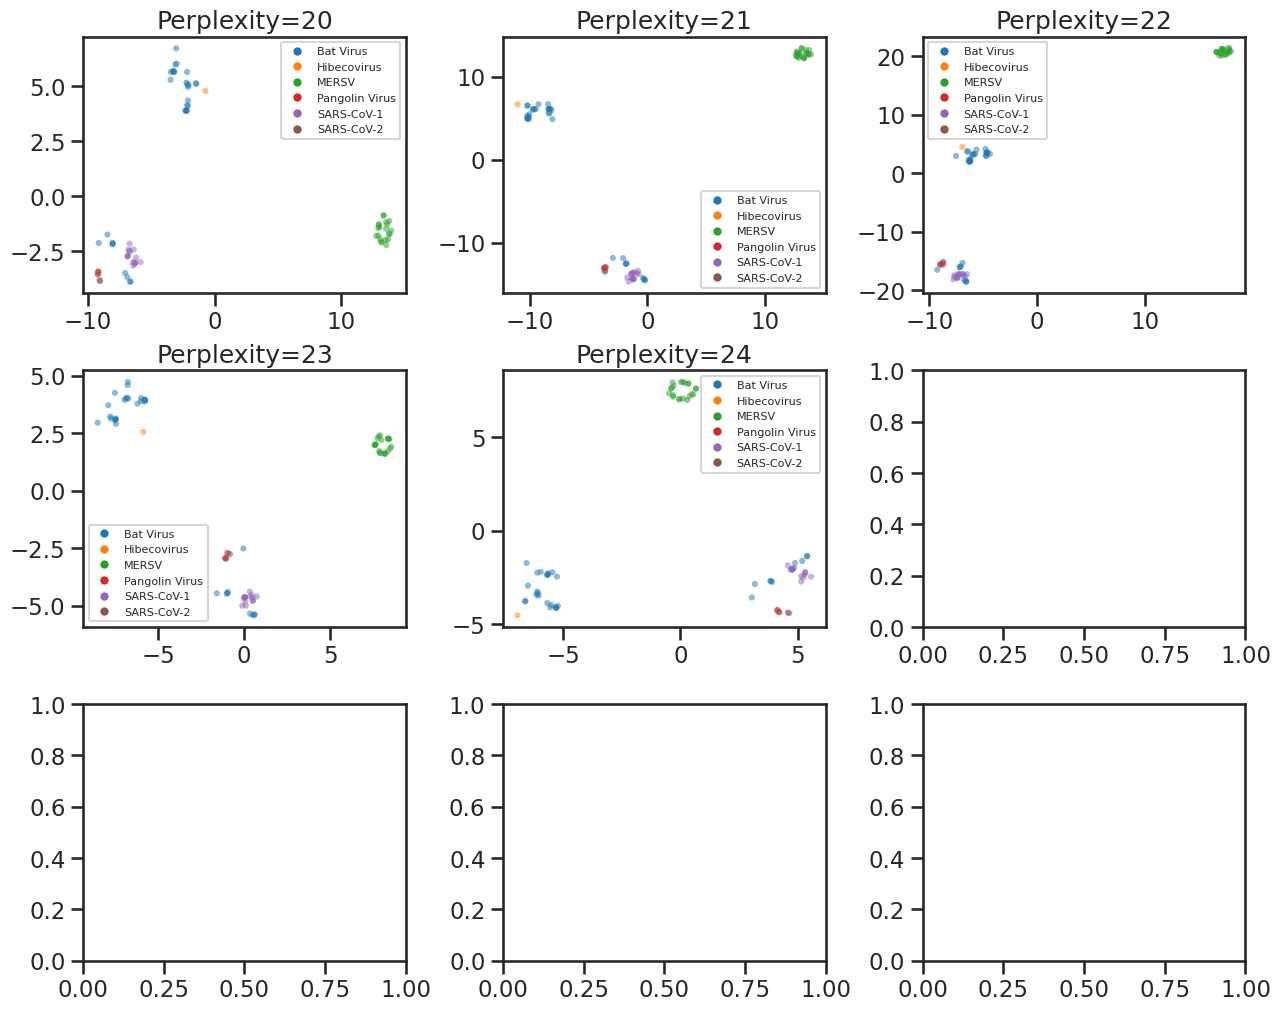

In [65]:
data_dir = "../../../data/betacov"
plot_perplexities(
    parquet_file = os.path.join(data_dir, f"betacoronavirus_seq.CLS-embedded.parquet"),
    perp_list = range(1,10)
)
plot_perplexities(
    parquet_file = os.path.join(data_dir, f"betacoronavirus_seq.CLS-embedded.parquet"),
    perp_list = range(10,20)
)
plot_perplexities(
    parquet_file = os.path.join(data_dir, f"betacoronavirus_seq.CLS-embedded.parquet"),
    perp_list = range(20, 25)
)

min_sample 1, min_cluster_size 2: Adjusted Rand Index: 0.14, Silhouette Coefficient: 0.48
min_sample 1, min_cluster_size 3: Adjusted Rand Index: 0.23, Silhouette Coefficient: 0.53
min_sample 1, min_cluster_size 4: Adjusted Rand Index: 0.48, Silhouette Coefficient: 0.72
min_sample 1, min_cluster_size 5: Adjusted Rand Index: 0.47, Silhouette Coefficient: 0.70
min_sample 1, min_cluster_size 6: Adjusted Rand Index: 0.47, Silhouette Coefficient: 0.70
min_sample 1, min_cluster_size 7: Adjusted Rand Index: 0.47, Silhouette Coefficient: 0.70
min_sample 1, min_cluster_size 8: Adjusted Rand Index: 0.59, Silhouette Coefficient: 0.70
min_sample 1, min_cluster_size 9: Adjusted Rand Index: 0.72, Silhouette Coefficient: 0.75
min_sample 1, min_cluster_size 10: Adjusted Rand Index: 0.72, Silhouette Coefficient: 0.75
min_sample 1, min_cluster_size 11: Adjusted Rand Index: 0.72, Silhouette Coefficient: 0.75
min_sample 1, min_cluster_size 12: Adjusted Rand Index: 0.59, Silhouette Coefficient: 0.76
min_sam

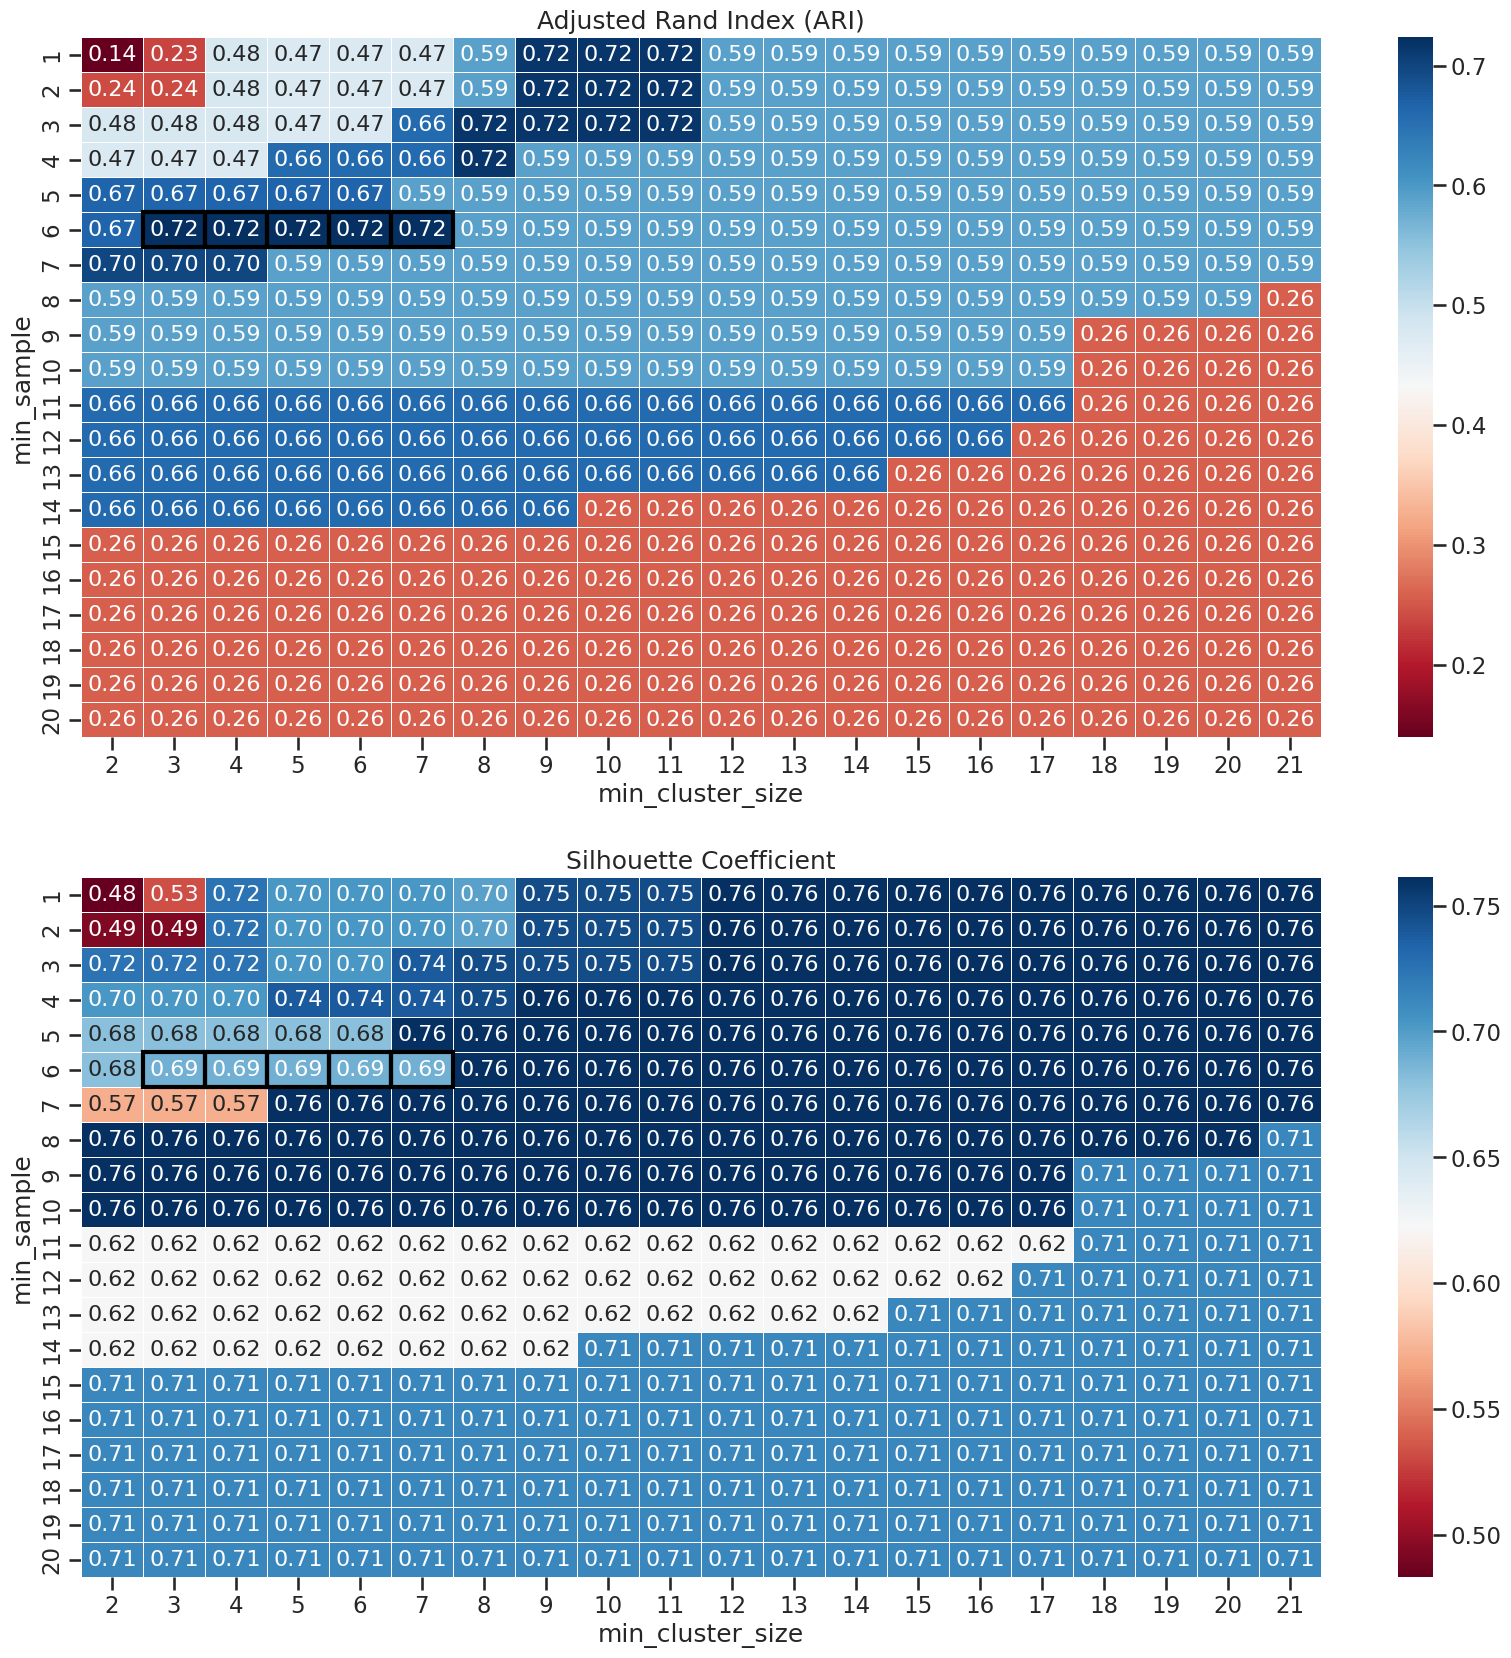

In [63]:
data_dir = "../../../data/betacov"
parquet_file = os.path.join(data_dir, f"betacoronavirus_seq.CLS-embedded.parquet")
embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_df["embedding"])

# Save the embedding based off best perplexity
perp = 7
tsne_reducer = TSNE(n_components=2, perplexity=perp, learning_rate='auto', random_state=42, n_jobs=8)
embedding_matrix_reduced = tsne_reducer.fit(embedding_matrix)

plot_df = pd.DataFrame({
    't-SNE component 1': embedding_matrix_reduced[:, 0],
    't-SNE component 2': embedding_matrix_reduced[:, 1],
    'Seq ID': embedded_df['seq_id'],
    'Variant': embedded_df['variant'],
    'Host': embedded_df['host']
})
save_as = f"BETACOV.CLS-embedded.tSNE-perplexity{perp}.parquet"
plot_df.to_parquet(save_as, engine='fastparquet')

# Load the embedding
perp = 7
parquet_file = f"BETACOV.CLS-embedded.tSNE-perplexity{perp}.parquet"
ari_sc_heatmap(parquet_file, min_samples_max=21, min_cluster_size_max=22)

min_sample 6, min_cluster_size 3: Adjusted Rand Index: 0.72, Silhouette Coefficient: 0.69


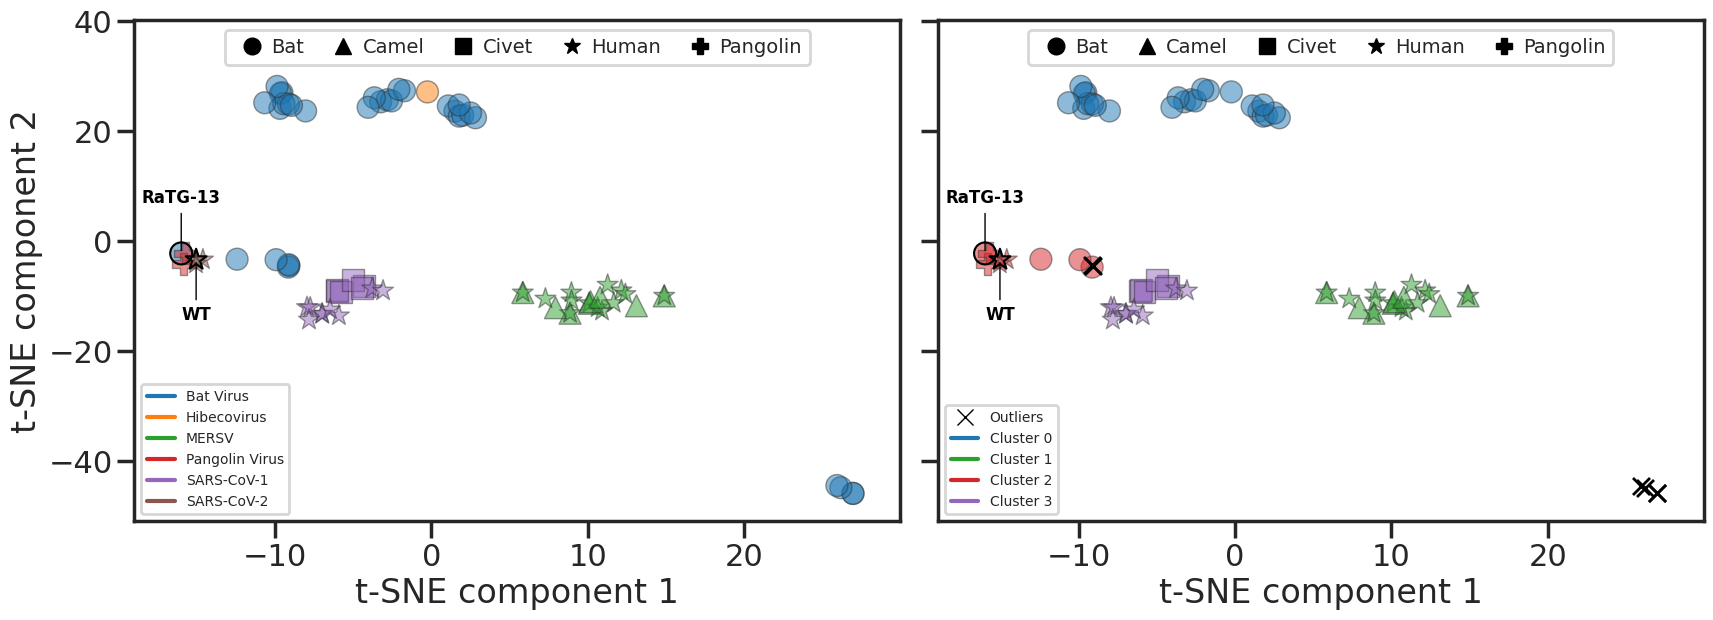

   t-SNE component 1  t-SNE component 2  Cluster    Seq ID    Variant Host
3          26.981716         -45.836935       -1  KT444582  Bat Virus  Bat
5          26.981716         -45.836934       -1  KF367457  Bat Virus  Bat
6          26.207222         -44.793956       -1  KY417151  Bat Virus  Bat
9          25.952185         -44.400042       -1  KF569996  Bat Virus  Bat


Predicted Clusters,-1,0,1,2,3
Ground Truth,,,,,
Bat Virus,18.18,69.7,0.0,12.12,0.0
Hibecovirus,0.00,100.0,0.0,0.00,0.0
MERSV,0.00,0.0,100.0,0.00,0.0
Pangolin Virus,0.00,0.0,0.0,100.00,0.0
SARS-CoV-1,0.00,0.0,0.0,0.00,100.0
SARS-CoV-2,0.00,0.0,0.0,100.00,0.0


In [11]:
seed = 0
perp = 7
parquet_file = f"BETACOV.CLS-embedded.tSNE-perplexity{perp}.parquet"

min_samples=6
min_cluster_size=3
plot_df, truth_table_percent, save_as = get_hdbscan_values(parquet_file, min_samples, min_cluster_size)

# Call the function
annotation_labels = {
    'MN908947':(0,-40),
    'MN996532':(0,40),
    # 'KF569996':(-75,0),
    # 'KT444582':(-10,-40),
    # 'KF367457':(-5,100),
    # 'KY417151':(-50,55)
}
plot_groundtruth_prediction_1x2(
    plot_df, save_as, annotation_labels, 
    x_min_width_buffer=3, x_max_width_buffer=3, y_min_width_buffer=5, y_max_width_buffer=12, 
    color_map="tab10",cluster_color_palette_order=[0,2,3,4,5,1,6,7,8,9]
)
truth_table_percent

In [12]:
phylo_df = plot_df.drop(columns=["t-SNE component 1", "t-SNE component 2"])
phylo_df.to_csv("betacov_clustering.csv", index=False)